In [1]:
# import sys
# sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
# sys.path.insert(0, '/cndd/fangming/CEMBA/scripts/ClusterCrossValidation')

# from __init__ import *
# from __init__jupyterlab import *
# import seaborn as sns
# set_matplotlib_formats('retina')
# import importlib
# import snmcseq_utils
# importlib.reload(snmcseq_utils)
# from matplotlib import collections as mc


# import pickle
# import xarray
# import fbpca
# from sklearn.model_selection import KFold
# from sklearn.metrics import adjusted_rand_score
# from sklearn.metrics import r2_score
# import itertools
# from scipy import sparse
# from scipy.stats import spearmanr
# from scipy import optimize
# from scipy.optimize import root_scalar
# from scipy import stats
# from statsmodels.stats.multitest import multipletests

# import CEMBA_run_tsne
# import CEMBA_clst_utils
# import cluster_cv_utils
# importlib.reload(cluster_cv_utils)
# from cluster_cv_utils import *

# import gseapy

In [2]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
import datetime
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

# Process the data 

In [3]:
log = snmcseq_utils.create_logger()
logging.info('*')

01/07/2020 02:19:58 PM *


In [4]:
time_stamp = datetime.datetime.now().date()
print(time_stamp)

# config_dir = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/' 
# sys.path.insert(0, config_dir)
config_f = 'config_scf_8mods_data_freeze_190917.py' 
exec("from {} import *".format(config_f.split('.')[0]))
output_figures = '/cndd/fangming/CEMBA/data/MOp_all/results/figures/mop_8mods_0915_k30_{{}}_{}.{{}}'.format(time_stamp)

f_joint_clustering = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_clusterings.tsv'
f_cluster_annot = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_annotation.tsv'
f_mod_annot = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_datamod_annotation.tsv'


2020-01-07


In [5]:
# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

In [6]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape)

snmcseq_gene (9366, 32)
snatac_gene (54844, 13)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


smarter_cells (6244, 129)
smarter_nuclei (5911, 146)
10x_cells_v2 (121440, 8)
10x_cells_v3 (69727, 8)
10x_nuclei_v3 (39706, 8)
10x_nuclei_v3_macosko (101647, 19)


In [7]:
# get results summary
mods_selected = [
#     'snatac_gene',
    'snmcseq_gene',
#     'smarter_nuclei',
    'smarter_cells',
#     '10x_cells_v3',
#     '10x_nuclei_v3',
#     '10x_nuclei_v3_macosko',
#     '10x_cells_v2', 
]
mods_ordered = [
#     'snatac_gene',
    'snmcseq_gene',
#     'smarter_nuclei',
    'smarter_cells',
#     '10x_cells_v3',
#     '10x_nuclei_v3',
#     '10x_nuclei_v3_macosko',
#     '10x_cells_v2', 
    ]
assert set(mods_ordered) == set(mods_selected)

f = f_cluster_annot
df_annot = pd.read_csv(f, sep="\t") 

f = f_mod_annot
df_mod_annot = pd.read_csv(f, sep="\t", index_col='Modality') 

f = f_joint_clustering
df_info = pd.read_csv(f, sep="\t") 

# back compatible
df_info = pd.merge(df_info, df_mod_annot[['Name']], left_on='modality', right_index=True)
df_info['modality_name'] = df_info['Name']
df_info = df_info.drop('Name', axis=1)

df_info = pd.merge(df_info, df_annot[['cluster_id_iterative', 'annotation_curated', 'color']], 
                   left_on='joint_cluster_round3', right_on='cluster_id_iterative', )

df_info = df_info.rename(columns={
                'joint_embedding_x': 'tsne_x_joint',
                'joint_embedding_y': 'tsne_y_joint',
                'single_modality_annot': 'annot',
                'single_modality_cluster': 'cluster',
                'annotation_curated': 'joint_cluster_round3_anno',
                'color': 'joint_cluster_round3_color',
            }).drop('cluster_id_iterative', axis=1)
df_info = df_info.set_index('sample')

print(df_info.shape)
df_info.head()


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(408885, 12)


,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot,joint_cluster_round1,joint_cluster_round2,joint_cluster_round3,joint_cluster_round4,joint_cluster_round3_anno,joint_cluster_round3_color
sample,,,,,,,,,,,,
snmcseq_gene_2C_M_0,0.471629,-3.134735,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2,1,1-1,1-1-1,1-1-1-1,L5 IT Rspo1,#3CBC78
snmcseq_gene_2C_M_1011,-0.091199,-2.604921,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2,1,1-1,1-1-1,1-1-1-1,L5 IT Rspo1,#3CBC78
snmcseq_gene_2C_M_1012,-0.037576,-8.106225,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,1,1-1,1-1-1,1-1-1-1,L5 IT Rspo1,#3CBC78
snmcseq_gene_2C_M_1022,0.906631,-0.785923,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Cpne4,L4-IT-Rorb_Rorb-Cpne4,1,1-1,1-1-1,1-1-1-1,L5 IT Rspo1,#3CBC78
snmcseq_gene_2C_M_1024,1.627603,-1.945875,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Cpne4,L4-IT-Rorb_Rorb-Cpne4,1,1-1,1-1-1,1-1-1-1,L5 IT Rspo1,#3CBC78


In [8]:
# back compatible
# update settings
settings_new = collections.OrderedDict()
for mod, mod_info in settings.items():
    new_dict = collections.OrderedDict()
    for item_key in mod_info._asdict().keys():
        if item_key == 'name':
            new_dict[item_key] = df_mod_annot.loc[mod, 'Name'] 
        elif item_key == 'color':
            new_dict[item_key] = df_mod_annot.loc[mod, 'Color'] 
        else:
            # unchanged 
            new_dict[item_key] = mod_info._asdict()[item_key]
    
    _items = [val for key, val in new_dict.items()]
    settings_new[mod] = Mod_info(*_items) 
settings = settings_new
# settings

### Get feature matrix 

In [9]:
df_genes = pd.read_csv(PATH_GENEBODY_ANNOTATION, sep='\t')
df_genes['gene_id_abbr'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes = df_genes.set_index('gene_id_abbr')
print(df_genes.shape)
df_genes.head()

(53379, 7)


,gene_id,gene_name,chr,start,end,strand,gene_type
gene_id_abbr,,,,,,,
ENSMUSG00000102693,ENSMUSG00000102693.1,4933401J01Rik,chr1,3073253,3074322,+,TEC
ENSMUSG00000064842,ENSMUSG00000064842.1,Gm26206,chr1,3102016,3102125,+,snRNA
ENSMUSG00000051951,ENSMUSG00000051951.5,Xkr4,chr1,3205901,3671498,-,protein_coding
ENSMUSG00000102851,ENSMUSG00000102851.1,Gm18956,chr1,3252757,3253236,+,processed_pseudogene
ENSMUSG00000103377,ENSMUSG00000103377.1,Gm37180,chr1,3365731,3368549,-,TEC


In [10]:
df_genes_v2 = df_genes.reset_index().groupby('gene_name').first()
df_genes_v2.head()

,gene_id_abbr,gene_id,chr,start,end,strand,gene_type
gene_name,,,,,,,
0610005C13Rik,ENSMUSG00000109644,ENSMUSG00000109644.1,chr7,45567794,45575327,-,antisense_RNA
0610006L08Rik,ENSMUSG00000108652,ENSMUSG00000108652.1,chr7,74818818,74853813,-,lincRNA
0610009B22Rik,ENSMUSG00000007777,ENSMUSG00000007777.9,chr11,51685386,51688874,-,protein_coding
0610009E02Rik,ENSMUSG00000086714,ENSMUSG00000086714.1,chr2,26445696,26459390,+,processed_transcript
0610009L18Rik,ENSMUSG00000043644,ENSMUSG00000043644.4,chr11,120348678,120351190,+,bidirectional_promoter_lncRNA


In [11]:
f_meta_format = '{0}/{1}_metadata.tsv'
f_data_format = '{0}/{1}_{2}raw.{3}'
f_hvftr_format = '{0}/{1}_hvfeatures.{2}'
f_ftr_format = '{0}/{1}_features.{2}'

In [12]:
gxc_ftrs = {}
for mod in mods_selected:
    ti = time.time()
    print(mod)
    
    # read data matrix
    if settings[mod].mod_category == 'mc':
        f_data = f_ftr_format.format(DATA_DIR, mod, 'tsv')
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        gxc_ftrs[mod] = pd.read_csv(f_data, sep='\t', index_col=0)
        print(time.time()-ti)
        
    else:
        f_data = f_ftr_format.format(DATA_DIR, mod, 'npz') 
        f_data_gene = f_ftr_format.format(DATA_DIR, mod, 'gene') 
        f_data_cell = f_ftr_format.format(DATA_DIR, mod, 'cell') 
        
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        gxc_ftrs[mod] = snmcseq_utils.load_gc_matrix(f_data_gene, f_data_cell, f_data) # checked dimensions in agreement internally
        print(gxc_ftrs[mod].data.shape)
        print(time.time()-ti)
    
    print(mod, "Total time used: {}".format(time.time()-ti))
    

snmcseq_gene
snmcseq_gene Reading in files 0.0002589225769042969
131.00294947624207
snmcseq_gene Total time used: 131.00315737724304
smarter_cells
smarter_cells Reading in files 3.218650817871094e-05
(32324, 6244)
13.371939897537231
smarter_cells Total time used: 13.371980667114258


In [79]:
f_data = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/snmcseq_gene_features_mcg.tsv'
gxc_ftrs['snmcseq_gene_mcg'] = pd.read_csv(f_data, sep='\t', index_col=0)

In [80]:
print(gxc_ftrs['snmcseq_gene_mcg'].shape)
gxc_ftrs['snmcseq_gene_mcg'].head()

(10318, 9366)


,snmcseq_gene_2C_M_0,snmcseq_gene_2C_M_1,snmcseq_gene_2C_M_100,snmcseq_gene_2C_M_1000,snmcseq_gene_2C_M_1001,snmcseq_gene_2C_M_1002,snmcseq_gene_2C_M_1003,snmcseq_gene_2C_M_1004,snmcseq_gene_2C_M_1005,snmcseq_gene_2C_M_1006,...,snmcseq_gene_5D_M_990,snmcseq_gene_5D_M_991,snmcseq_gene_5D_M_992,snmcseq_gene_5D_M_993,snmcseq_gene_5D_M_994,snmcseq_gene_5D_M_995,snmcseq_gene_5D_M_996,snmcseq_gene_5D_M_997,snmcseq_gene_5D_M_998,snmcseq_gene_5D_M_999
ENSMUSG00000051951,0.927889,1.127662,1.041682,1.000709,1.127190,1.056551,0.991620,1.005510,1.124077,1.027323,...,0.946192,1.023840,1.044784,1.059582,1.009258,1.080610,1.063738,1.062934,1.066601,1.057163
ENSMUSG00000102343,1.094741,1.204715,1.274346,1.068506,1.281010,1.110270,1.205094,1.204637,1.094691,1.119629,...,1.127857,1.103604,1.284802,1.169835,1.226061,1.247847,1.131252,1.063990,1.211108,1.066679
ENSMUSG00000025900,1.223751,1.181548,1.276258,1.104059,1.197846,1.136394,1.119016,1.117561,1.157407,1.163425,...,1.138709,1.133095,1.103612,1.162994,1.123889,1.177215,1.081222,0.960251,1.110183,1.156682
ENSMUSG00000025903,1.245572,1.165854,1.244710,0.778483,0.945507,1.202052,1.173793,1.113108,1.005291,1.046020,...,1.009966,1.051051,0.817601,0.998947,1.037436,1.247847,1.165487,1.024973,1.211108,1.132176
ENSMUSG00000104217,1.254222,0.643711,1.111348,0.835659,0.951902,0.858609,1.110408,0.878629,0.983584,1.018974,...,1.182739,1.128128,1.107588,1.231406,0.886938,1.195854,1.131667,1.218363,1.211108,1.163501


### Calculate things 

In [13]:
X = gxc_ftrs['snmcseq_gene']
Y = pd.DataFrame(gxc_ftrs['smarter_cells'].data.todense(), 
                 index=gxc_ftrs['smarter_cells'].gene, 
                 columns=gxc_ftrs['smarter_cells'].cell)

shared_genes = np.intersect1d(X.index, Y.index)
n_genes = len(shared_genes)

X = X.loc[shared_genes, :].T
Y = Y.loc[shared_genes, :].T

print(X.shape, Y.shape)

(9366, 16767) (6244, 16767)


In [74]:
X2.head()

,ENSMUSG00000000001,ENSMUSG00000000028,ENSMUSG00000000037,ENSMUSG00000000049,ENSMUSG00000000056,ENSMUSG00000000058,ENSMUSG00000000078,ENSMUSG00000000085,ENSMUSG00000000088,ENSMUSG00000000093,...,ENSMUSG00000115170,ENSMUSG00000115267,ENSMUSG00000115293,ENSMUSG00000115338,ENSMUSG00000115697,ENSMUSG00000115701,ENSMUSG00000115705,ENSMUSG00000115744,ENSMUSG00000115791,ENSMUSG00000115792
snmcseq_gene_2C_M_0,0.973103,NaN,NaN,0.920786,NaN,NaN,NaN,1.195709,NaN,NaN,...,NaN,NaN,0.423664,NaN,NaN,NaN,NaN,NaN,NaN,NaN
snmcseq_gene_2C_M_1,0.880867,NaN,NaN,0.511069,NaN,NaN,NaN,0.620202,NaN,NaN,...,NaN,NaN,0.562776,NaN,NaN,NaN,NaN,NaN,NaN,NaN
snmcseq_gene_2C_M_100,1.143101,NaN,NaN,1.119580,NaN,NaN,NaN,1.113506,NaN,NaN,...,NaN,NaN,0.565092,NaN,NaN,NaN,NaN,NaN,NaN,NaN
snmcseq_gene_2C_M_1000,0.819456,NaN,NaN,1.252731,NaN,NaN,NaN,1.123583,NaN,NaN,...,NaN,NaN,0.798444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
snmcseq_gene_2C_M_1001,0.782991,NaN,NaN,0.745760,NaN,NaN,NaN,1.045109,NaN,NaN,...,NaN,NaN,0.481779,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
X2 = gxc_ftrs['snmcseq_gene_mcg']
X2 = X2.T
print(X2.shape)

# get cluster mean
centroids_x2 = {}
delta_X2 = X2.copy()
for clst, df_sub in df_info.groupby('joint_cluster_round3'):
    print(clst, end='')
    cells_sub = df_sub.index.values
    cells_sub_x2 = np.intersect1d(cells_sub, X2.index.values)
    centroids_x2[clst] = X2.loc[cells_sub_x2].mean()
    delta_X2.loc[cells_sub_x2] -= centroids_x2[clst]
# get eta_squared
eta_squared_X2 = 1 - (delta_X2.std(axis=0)/X2.std(axis=0))**2

(9366, 10318)
1-1-11-2-11-2-210-1-12-1-12-1-22-2-12-2-22-2-32-2-42-3-12-3-22-3-33-1-13-1-23-2-13-2-23-3-14-1-14-1-24-2-14-2-24-2-35-1-15-1-25-2-15-2-25-2-35-3-15-3-25-4-15-5-16-1-16-1-26-2-16-3-16-3-26-3-36-4-16-4-26-5-16-5-26-5-36-6-17-1-17-1-27-2-17-2-28-1-18-1-28-2-18-3-18-3-29-1-19-2-19-2-2

In [14]:
print(len(shared_genes))
shared_gene_names = df_genes.reindex(shared_genes)['gene_name'].values
print(len(shared_gene_names))

16767
16767


In [15]:
# X and Y are cell by gene matrices

# get cluster mean
centroids_x = {}
centroids_y = {}
delta_X = X.copy()
delta_Y = Y.copy()
for clst, df_sub in df_info.groupby('joint_cluster_round3'):
    print(clst, end='')
    cells_sub = df_sub.index.values
    cells_sub_x = np.intersect1d(cells_sub, X.index.values)
    cells_sub_y = np.intersect1d(cells_sub, Y.index.values)
    
    centroids_x[clst] = X.loc[cells_sub_x].mean()
    centroids_y[clst] = Y.loc[cells_sub_y].mean()
    delta_X.loc[cells_sub_x] -= centroids_x[clst]
    delta_Y.loc[cells_sub_y] -= centroids_y[clst]
    
# get eta_squared
eta_squared_X = 1 - (delta_X.std(axis=0)/X.std(axis=0))**2
eta_squared_Y = 1 - (delta_Y.std(axis=0)/Y.std(axis=0))**2

1-1-11-2-11-2-210-1-12-1-12-1-22-2-12-2-22-2-32-2-42-3-12-3-22-3-33-1-13-1-23-2-13-2-23-3-14-1-14-1-24-2-14-2-24-2-35-1-15-1-25-2-15-2-25-2-35-3-15-3-25-4-15-5-16-1-16-1-26-2-16-3-16-3-26-3-36-4-16-4-26-5-16-5-26-5-36-6-17-1-17-1-27-2-17-2-28-1-18-1-28-2-18-3-18-3-29-1-19-2-19-2-2

In [82]:
centroids_df_x = pd.DataFrame(centroids_x).dropna(axis=1)
centroids_df_x2 = pd.DataFrame(centroids_x2).dropna(axis=1)
centroids_df_y = pd.DataFrame(centroids_y).dropna(axis=1)
shared_celltypes = np.intersect1d(centroids_df_x.columns.values, 
                                  centroids_df_y.columns.values
                                 )
centroids_df_x = centroids_df_x[shared_celltypes]
centroids_df_x2 = centroids_df_x2[shared_celltypes]
centroids_df_y = centroids_df_y[shared_celltypes]

print(centroids_df_x.shape)
print(centroids_df_x2.shape)
print(centroids_df_y.shape)
centroids_df_x.head()

(16767, 52)
(10318, 52)
(16767, 52)


,1-1-1,1-2-1,1-2-2,10-1-1,2-1-1,2-1-2,2-2-1,2-2-2,2-3-1,2-3-2,...,7-1-2,7-2-1,7-2-2,8-1-1,8-1-2,8-2-1,8-3-1,9-1-1,9-2-1,9-2-2
ENSMUSG00000000001,0.704035,0.528840,0.500647,0.376097,0.676029,0.727378,0.637312,0.667760,0.751751,0.561560,...,0.569570,0.483519,0.537165,0.437665,0.519713,0.569403,0.903362,0.929236,0.542235,0.738552
ENSMUSG00000000028,1.555377,1.491901,1.505999,1.316399,1.143546,1.257018,1.092309,1.042713,1.147668,1.266663,...,1.176880,1.210865,1.426477,1.114649,1.322028,1.122437,0.868914,1.611191,1.388178,1.521911
ENSMUSG00000000037,1.084393,1.077811,1.076317,0.962418,1.019554,1.035278,0.949949,0.979284,1.027491,1.106304,...,1.164485,1.104150,1.106977,1.126285,1.056200,0.980576,0.565460,1.175892,1.125413,1.074202
ENSMUSG00000000049,1.445036,1.490492,1.424849,1.261260,1.704159,1.683838,1.673108,1.598400,1.646323,1.625410,...,1.203387,1.176499,1.165158,1.312784,1.261885,1.185871,1.106056,1.630861,1.592927,1.587191
ENSMUSG00000000056,0.314842,0.280615,0.283175,0.180750,0.319041,0.299865,0.274846,0.258925,0.345669,0.256681,...,0.267841,0.223673,0.215661,0.186938,0.262993,0.292211,0.139237,0.282495,0.314486,0.231948


In [17]:
def spearmanr_paired_rows(X, Y):
    from scipy import stats
    
    X = np.array(X)
    Y = np.array(Y)
    corrs = []
    ps = []
    for x, y in zip(X, Y):
        r, p = stats.spearmanr(x, y)
        corrs.append(r)
    return np.array(corrs), np.array(ps)

In [39]:
gene_corr, _ = spearmanr_paired_rows(centroids_df_x, centroids_df_y)
print(gene_corr)
# gene_corr_shuffled, _ = spearmanr_paired_rows(X.sample(frac=1).T, Y.sample(frac=1).T)

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


[ 0.32126697 -0.23846551 -0.11854871 ...,         nan         nan
         nan]


In [52]:
chosen_clusters = centroids_df_x.filter(regex='6-', axis=1).columns.values
print(chosen_clusters)

['6-1-1' '6-1-2' '6-2-1' '6-3-1' '6-3-2' '6-3-3' '6-4-1' '6-4-2' '6-5-1'
 '6-5-2' '6-5-3' '6-6-1']


In [59]:
xs = collections.OrderedDict({
    'eta_squared_mCH': eta_squared_X.values, 
    'eta_squared_RNA': eta_squared_Y.values, 
    'expression_RNA': centroids_df_y.mean(axis=1).values,
    'expression_RNA_max': centroids_df_y.max(axis=1).values,
    'low_mCH_chosen_cluster': (centroids_df_x[chosen_clusters].mean(axis=1) - centroids_df_x.drop(chosen_clusters, axis=1).median(axis=1)).values,
#     'corr': gene_corr, 
})
xs_df = pd.DataFrame(xs, index=shared_gene_names)

In [54]:
print(xs_df.shape)
xs_df.head()

(16767, 5)


,eta_squared_mCH,eta_squared_RNA,expression_RNA,expression_RNA_max,low_mCH_chosen_cluster
Gnai3,0.036292,0.044153,0.662310,1.178118,0.135694
Cdc45,0.076379,0.021742,0.049513,0.297635,0.160665
Scml2,0.026454,0.022336,0.011225,0.075636,0.339349
Apoh,0.245894,0.121647,0.036681,0.223523,0.074684
Narf,0.017528,0.092173,1.089741,1.803522,0.182444


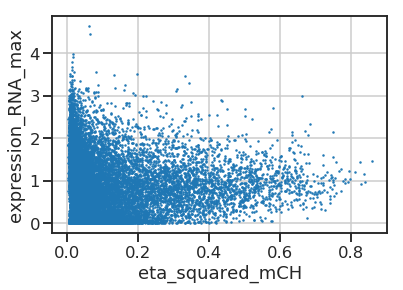

In [55]:
fig, ax = plt.subplots()
ax.scatter(xs['eta_squared_mCH'], xs['expression_RNA_max'], s=1, rasterized=True)
ax.set_xlabel('eta_squared_mCH')
ax.set_ylabel('expression_RNA_max')
plt.show()

In [35]:
xs_df[xs_df['eta_squared_mCH'] > 0.5].sort_values('expression_RNA_max', ascending=True).head(30)

,eta_squared_mCH,eta_squared_RNA,expression_RNA,expression_RNA_max
Gm11149,0.573640,0.017209,0.008348,0.037674
Gm36367,0.548594,0.022786,0.009036,0.048129
Enthd1,0.576883,0.013559,0.006621,0.058564
Spata16,0.525596,0.085742,0.008007,0.062120
Sh3rf2,0.525510,0.027160,0.007010,0.067320
Gm12002,0.546643,0.024576,0.007863,0.074504
Glis3,0.676377,0.059554,0.019756,0.112034
Rsph14,0.558617,0.019005,0.011171,0.126436
Ly86,0.542943,0.044797,0.018423,0.131208
Filip1l,0.512307,0.051562,0.018116,0.175505


In [60]:
xs_df[((xs_df['eta_squared_mCH'] > 0.3) & (xs_df['expression_RNA_max'] < 0.2))].sort_values('low_mCH_chosen_cluster', ascending=True).head(30)

,eta_squared_mCH,eta_squared_RNA,expression_RNA,expression_RNA_max,low_mCH_chosen_cluster
Smco4,0.321801,0.099358,0.035843,0.190677,-0.741220
Hcn4,0.423494,0.040126,0.026863,0.108252,-0.737275
Hsf2bp,0.340692,0.022326,0.023747,0.134744,-0.563232
Zfp516,0.446900,0.046144,0.042223,0.171077,-0.514083
Nxn,0.324494,0.051162,0.035441,0.128285,-0.513533
Gm8257,0.309779,0.002956,0.000011,0.000573,-0.486398
Gm11571,0.419347,0.005029,0.000187,0.001671,-0.445232
Angpt2,0.303737,0.016455,0.014257,0.163463,-0.394461
Plekhh1,0.321425,0.049993,0.041298,0.193774,-0.379336
Fer1l6,0.389136,0.053789,0.018130,0.196627,-0.355121


In [56]:
xs_df[((xs_df['eta_squared_mCH'] > 0.3) & (xs_df['low_mCH_chosen_cluster'] < 0))].sort_values('expression_RNA_max', ascending=True).head(30)

,eta_squared_mCH,eta_squared_RNA,expression_RNA,expression_RNA_max,low_mCH_chosen_cluster
Parp4,0.382925,0.030621,0.021983,0.251972,-0.015990
Peli2,0.373821,0.110199,0.066382,0.344369,-0.004013
Fbln2,0.379258,0.202021,0.068308,0.439638,-0.212907
Rxra,0.420753,0.132035,0.145978,0.461463,-0.507537
Cflar,0.338775,0.200149,0.089510,0.558717,-0.086580
Rb1,0.370788,0.060861,0.326878,0.602532,-0.039720
Wdr31,0.314415,0.057644,0.326456,0.606800,-0.000846
Rrp1b,0.597223,0.023904,0.335740,0.612436,-0.022396
Zfp862-ps,0.464249,0.027863,0.100668,0.636142,-0.005096
Lima1,0.331563,0.228642,0.116542,0.643705,-0.027159


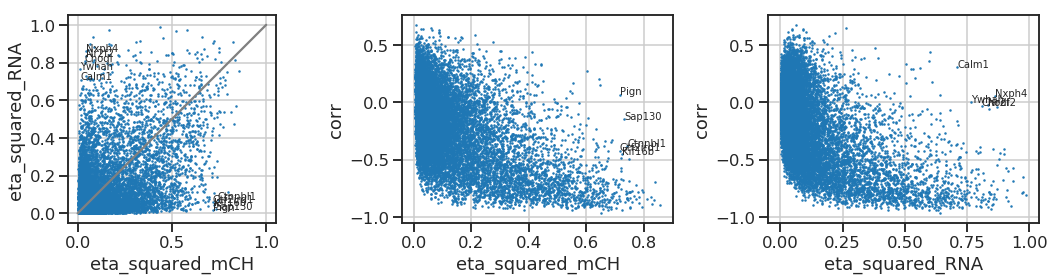

In [61]:

annot_dots_rna = xs_df[xs_df['eta_squared_RNA'] > 0.7].sort_values('corr', ascending=False).head()
annot_dots_mch = xs_df[xs_df['eta_squared_mCH'] > 0.7].sort_values('corr', ascending=False).head()

fig, axs = plt.subplots(1, 3, figsize=(5*3, 4))
ax = axs[0]
xlabel = 'eta_squared_mCH'
ylabel = 'eta_squared_RNA'
ax.scatter(xs[xlabel], xs[ylabel], 
           s=1, rasterized=True)
ax.plot([0, 1], [0, 1], color='gray')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_aspect('equal')
for gene, row in annot_dots_rna.iterrows():
    _x = row[xlabel] 
    _y = row[ylabel]
    ax.text(_x, _y, gene)
for gene, row in annot_dots_mch.iterrows():
    _x = row[xlabel] 
    _y = row[ylabel]
    ax.text(_x, _y, gene)

ax = axs[1]
xlabel = 'eta_squared_mCH'
ylabel = 'corr'
ax.scatter(xs[xlabel], xs[ylabel], 
           s=1, rasterized=True)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
for gene, row in annot_dots_mch.iterrows():
    _x = row[xlabel] 
    _y = row[ylabel]
    ax.text(_x, _y, gene)

ax = axs[2]
xlabel = 'eta_squared_RNA'
ylabel = 'corr'
ax.scatter(xs[xlabel], xs[ylabel], 
           s=1, rasterized=True)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
for gene, row in annot_dots_rna.iterrows():
    _x = row[xlabel] 
    _y = row[ylabel]
    ax.text(_x, _y, gene)

fig.tight_layout()
output = output_figures.format('eta_squared_mCH_SMART_RNA', 'pdf')
# fig.savefig(output, bbox_inches='tight', dpi=300)
plt.show()

In [58]:
print(gene, _x, _y)

Calm1 0.709524063602 0.309485187399
Nxph4 0.859977175213 0.0561726553162
Ywhah 0.764289166772 0.00076837701699
Nr2f2 0.833381589841 -0.0255786451873
Chodl 0.809025597312 -0.0283015232438


In [63]:
xs_df[xs_df['eta_squared_RNA'] > 0.7].sort_values('corr', ascending=False).head()

,eta_squared_mCH,eta_squared_RNA,corr
Calm1,0.016619,0.709524,0.309485
Nxph4,0.046664,0.859977,0.056173
Ywhah,0.014066,0.764289,0.000768
Nr2f2,0.043149,0.833382,-0.025579
Chodl,0.038928,0.809026,-0.028302


In [64]:
xs_df[xs_df['eta_squared_mCH'] > 0.7].sort_values('corr', ascending=False).head()

,eta_squared_mCH,eta_squared_RNA,corr
Pign,0.716419,0.015436,0.068642
Sap130,0.731957,0.024132,-0.147614
Ctnnbl1,0.742076,0.073213,-0.379066
Gtf2ird1,0.716228,0.060110,-0.420814
Kif16b,0.725568,0.042132,-0.451976


In [84]:
# centroids_df_x2.shape

(10318, 52)

In [85]:
# f = '/cndd2/fangming/miniatlas/mcg_round3.tsv'
# centroids_df_x2.to_csv(f, sep='\t')

In [65]:
# f = '/cndd2/fangming/miniatlas/mch_round3.tsv'
# centroids_df_x.to_csv(f, sep='\t')

In [66]:
# f = '/cndd2/fangming/miniatlas/10x_v2_cells_round3.tsv'
# centroids_df_y.to_csv(f, sep='\t')